# Periodic Bspline

### Pacchetti

In [2]:
import pyBspline as Bs
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import scipy
from scipy.misc import derivative
from scipy.optimize import curve_fit
import pandas as pd
#from ipywidgets import interactive
#import ipywidgets as widgets
#from ipywidgets import AppLayout, FloatSlider
#from mpl_toolkits.mplot3d import Axes3D
import copy
import pandas as pd
#from scipy import integrate
#import itertools 
#import time
import os
import scipy.special
import re

## Triangle $k=20,P=1,N=100$

### Definition

In [3]:
k_in = 20*np.asarray([0.5,np.sqrt(3)/2])
wavevector = np.sqrt(np.sum(np.power(k_in,2.0)))
I = np.complex(0,1)

xmin = -1.5
xmax = 1.5
ymin = -1.5
ymax = 1.5

In [4]:
#definisco la dimensionaità:
sh = Bs.shape(1,2)
#sh.show()

#defiisco i knot vector
P=1 #polinomial degree
N=50 #base caridnality
xminBs = 0.0
xmaxBs = 1.0


#
#kv = Bs.uniform_open_kv(xmin,xmax,p=P,n=N)#Bs.knot_vector(P,N,v)
#kv = periodic_kv(xmin,xmax,p=P,n=N)
kv = Bs.periodic_kv(xminBs,xmaxBs,p=P,n=N)
#kv.show()

#alloco la Bspline
bs = Bs.Bspline(sh,[kv],periodic=[True])

In [5]:
file_dir = "files/BEM/triangle-periodic/"
suffix = "P="+str(P)+"-N="+str(N)+"-k="+str(wavevector)+".csv"

In [6]:
x0 = -0.5
y0 =  -0.5

a = 1.0 / (2+np.sqrt(2))
b = (1.0+np.sqrt(2)) / (2+np.sqrt(2))
delta = b-a

sx = 1.0
sy = 1.0

def triangle_x(i):
    if i <= a :
        return i
    elif i > a and i <= b :
        j = i-a
        return a - j*a/(delta)
    else :
        return 0
    
def triangle_y(i):
    if i <= a :
        return 0
    elif i > a and i <= b :
        j = i-a
        return j*a/(delta)
    else :
        j = i-b
        return a-j
    
def triangle(t):
    out = np.zeros((len(t),2))
    out[:,0] = [triangle_x(i) for i in t]
    out[:,1] = [triangle_y(i) for i in t]
            
    out[:,0] = sx*out[:,0]/a+x0
    out[:,1] = sy*out[:,1]/a+y0
    return out

In [7]:
t = np.linspace(0,1,N)
cp = triangle(t)
for i in range(len(t)):
    #bs._cp[i] = cp[i]
    bs.set_cp(i,cp[i])
cpx = cp[:,0]
cpy = cp[:,1]

In [8]:
#function
x0 = 0.0
y0 = 0.0
a = 0.5
b = 0.5
def func(t):
    #print(cpz)
    cpx = a*np.cos(2*np.pi*t)+x0#np.random.rand(N)
    cpy = b*np.sin(2*np.pi*t)+y0#np.random.rand(N)
    out = np.zeros(shape=(len(t),2))
    for i in range(len(t)):
        out[i,0] = cpx[i]
        out[i,1] = cpy[i]
    return out

In [9]:
t = np.linspace(0,1,N)
cp = func(t)
for i in range(len(t)):
    #bs._cp[i] = cp[i]
    bs.set_cp(i,cp[i])
cpx = cp[:,0]
cpy = cp[:,1]

### Geometry

In [8]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
df = pd.DataFrame(xy)
df = df.rename(columns={0:"x",1:"y"})

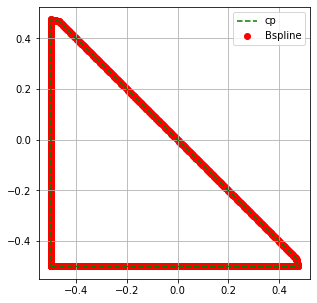

In [9]:
#grafico
fig = plt.figure ( 0 , figsize = ( 5, 5 ) )
   
#converto in dataframe    
ax = fig.add_subplot(111)
plt.plot(cpx,cpy,color="green",label="cp",linestyle="--")
plt.scatter(cpx,cpy,color="green")
plt.scatter(df["x"], df["y"], color= "red",label="Bspline")
plt.grid()
plt.legend()
ax.set_aspect('equal')
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)
plt.show()

### Stiffness Matrix

In [10]:
file = file_dir+"stiffness_matrix-"+suffix
file

'files/BEM/triangle-periodic/stiffness_matrix-P=1-N=50-k=20.0.csv'

In [11]:
READ = True
SAVE = False
if os.path.exists(file) and READ == True :
    sm = bs.load("sm-BEM",file)
else :
    sm = bs.stiffness_matrix_BEM(k=wavevector,opts={"print":True})
    if SAVE == True :
        bs.save("sm-BEM",file)
#sm

### Plane wave

In [19]:
def plot(fig,n,xB,yB,x,y,c,title,cmap):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return

In [26]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

#tolgo elementi interni
#radius = np.asarray([np.sqrt(np.sum(np.power(i,2.0))) for i in XY])
internal = bs.internal_points(XY=XY,NN=1000,xmin=0.,xmax=1.,opts=None)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
XYslp = XY[ np.logical_not(internal) ]
print(len(XYslp)," = ",len(XYslp)/3600,"h")

3392  =  0.9422222222222222 h


In [35]:
def plane_wave(xx): # soluzione
    xx = np.asarray(xx)
    theta = np.dot(xx,k_in)
    return np.exp(I*theta)

In [36]:
#
NN = 1000
T = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(T)
uinc = plane_wave(xy)

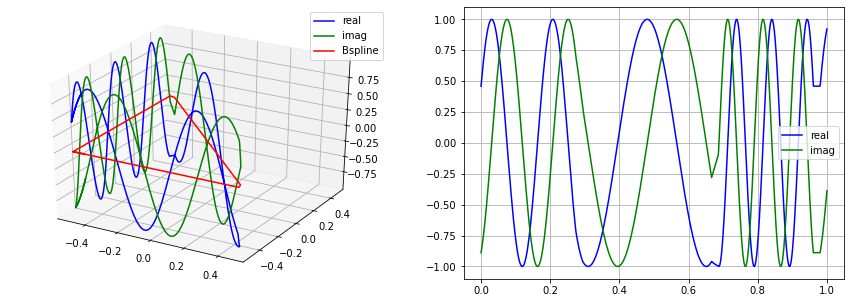

In [37]:
fig = plt.figure ( 0 , figsize = ( 15, 5 ) )

#
#s = 0.2
ax = fig.add_subplot(121, projection='3d')
ax.plot(xy[:,0], xy[:,1],uinc.real,color="blue",label="real")
ax.plot(xy[:,0], xy[:,1],uinc.imag,color="green",label="imag")
ax.plot(xy[:,0], xy[:,1],0.0,color="red",label="Bspline")
plt.grid(True)
plt.legend()

#
ax = fig.add_subplot(122)#, projection='3d')
ax.plot(T,uinc.real,color="blue",label="real")
ax.plot(T,uinc.imag,color="green",label="imag")
plt.grid(True)
plt.legend()

plt.show()

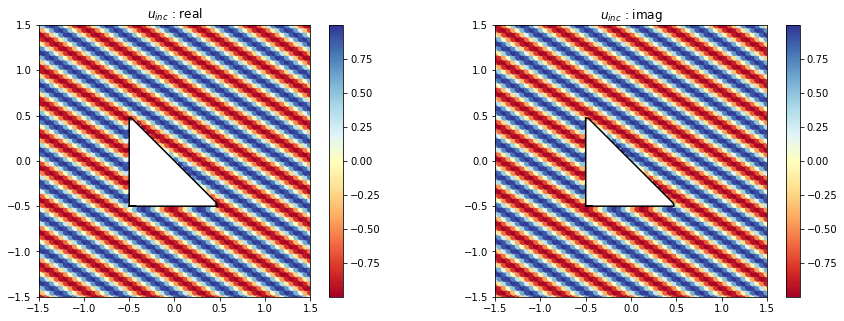

In [38]:
fig = plt.figure ( 0 , figsize = ( 15 , 5 ) )

Uinc = plane_wave(XYslp)

cmap = 'RdYlBu'
    
plot(fig,121,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.real,"$u_{inc}$ : real",cmap)
plot(fig,122,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.imag,"$u_{inc}$ : imag",cmap)

plt.show()

### Single Layer Potential basis

In [22]:
file = file_dir+"single_layer_potential-"+suffix
file

'files/BEM/triangle-periodic/single_layer_potential-P=1-N=50-k=20.0.csv'

In [23]:
READ = False
SAVE = True
if os.path.exists(file) and READ == True :
    slp = bs.load("slp-BEM",file)
else :
    slp = bs.single_layer_potential_basis_BEM(XY=XYslp,k=wavevector,opts={"print":True})
    if SAVE == True :
        bs.save("slp-BEM",file)
#slp

KeyboardInterrupt: 

### Winding number

In [25]:
Nx= int(xmax-xmin)*20
Ny = int(ymax-ymin)*20
x = np.linspace(xmin,xmax,Nx)
y = np.linspace(ymin,ymax,Ny)
X,Y = np.meshgrid(x,y)

XY = np.zeros((Nx*Ny,2))
XY[:,0] = X.reshape((Nx*Ny,))
XY[:,1] = Y.reshape((Nx*Ny,))

In [26]:
#
NN = 1000
t = np.linspace(xminBs,xmaxBs,NN,endpoint=True)
xy   = bs.evaluate(t)
area = max(t)-min(t)

def to_complex(xy):
    return np.asarray([ np.complex(i[0],i[1]) for i in xy ])

z = to_complex(xy)
der = bs.derivative()
d = der.evaluate(t)
jac = to_complex(d)#np.asarray([np.sqrt(np.sum(np.power(i,2.0))) for i in d ])

I = np.complex(0,1)

x0 = to_complex(XY)
wn = np.zeros(x0.shape,dtype=np.complex)

for i in range(len(x0)):
    delta = z-x0[i]
    integrand = jac /delta * area
    wn[i] = np.mean(integrand)/(2*np.pi*I)

In [28]:
np.absolute(wn) >0.5

array([False, False, False, ..., False, False, False])

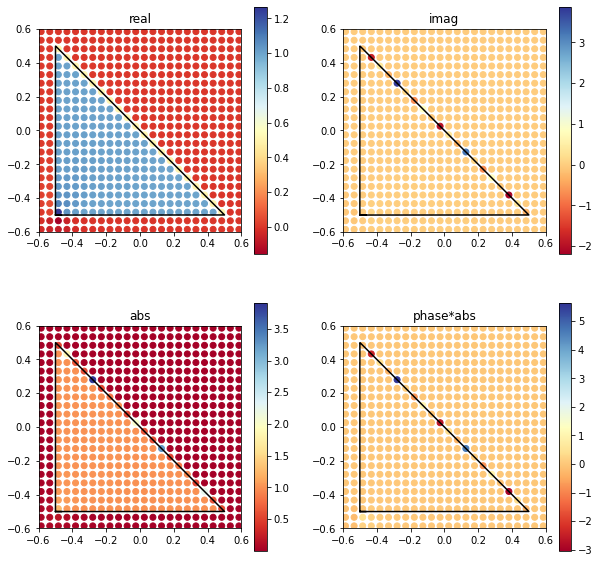

In [95]:
fig = plt.figure ( 0 , figsize = ( 10 , 10 ) )

cmap = 'RdYlBu'

h = 0.6

xminWN = -h
xmaxWn = h

yminWn = -h
ymaxWN = h
    
#
ax = fig.add_subplot(221)
ax.plot(xy[:,0], xy[:,1], color= "black",label="Bspline")
sc = ax.scatter(XYslp[:,0],XYslp[:,1],c=wn.real,cmap=cmap)
plt.colorbar(sc)
plt.xlim(xminWN,xmaxWn)
plt.ylim(yminWn,ymaxWN)
ax.set_aspect('equal')
plt.title("real")

ax = fig.add_subplot(222)
ax.plot(xy[:,0], xy[:,1], color= "black",label="Bspline")
sc = ax.scatter(XYslp[:,0],XYslp[:,1],c=wn.imag,cmap=cmap)
plt.colorbar(sc)
plt.xlim(xminWN,xmaxWn)
plt.ylim(yminWn,ymaxWN)
ax.set_aspect('equal')
plt.title("imag")

#
ax = fig.add_subplot(223)
ax.plot(xy[:,0], xy[:,1], color= "black",label="Bspline")
sc = ax.scatter(XYslp[:,0],XYslp[:,1],c=np.absolute(wn),cmap=cmap)
plt.colorbar(sc)
plt.xlim(xminWN,xmaxWn)
plt.ylim(yminWn,ymaxWN)
ax.set_aspect('equal')
plt.title("abs")

ax = fig.add_subplot(224)
ax.plot(xy[:,0], xy[:,1], color= "black",label="Bspline")
sc = ax.scatter(XYslp[:,0],XYslp[:,1],c=np.angle(wn)*np.absolute(wn),cmap=cmap)
plt.colorbar(sc)
plt.xlim(xminWN,xmaxWn)
plt.ylim(yminWn,ymaxWN)
ax.set_aspect('equal')
plt.title("phase*abs")

plt.show()

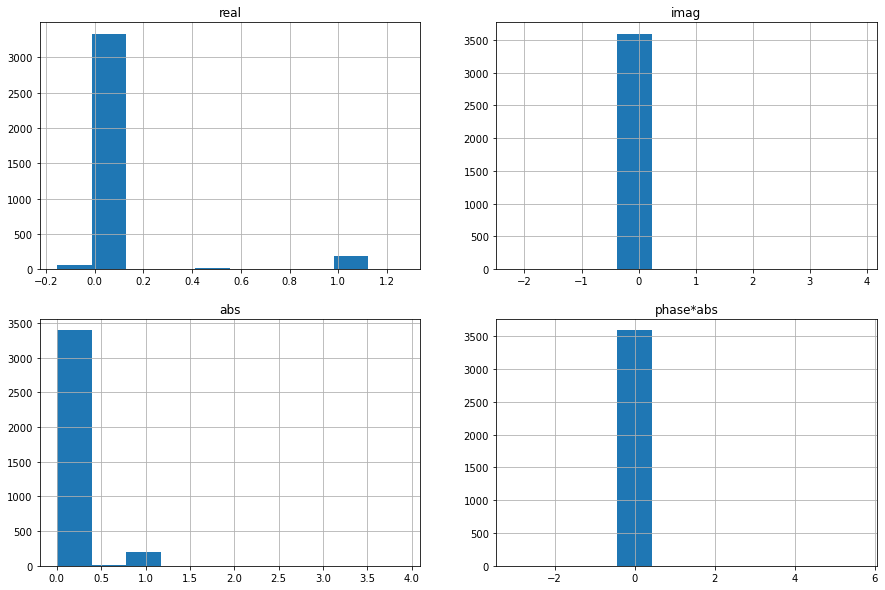

In [96]:
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

#plot(fig,331,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.real,"$u_{inc}$ : real")
    
bins = 10
#
ax = fig.add_subplot(221)
plt.hist(wn.real,bins=bins)
plt.title("real")
plt.grid(True)

ax = fig.add_subplot(222)
plt.hist(wn.imag,bins=bins)
plt.title("imag")
plt.grid(True)

#
ax = fig.add_subplot(223)
plt.hist(np.absolute(wn),bins=bins)
plt.title("abs")
plt.grid(True)

ax = fig.add_subplot(224)
plt.hist(np.angle(wn)*np.absolute(wn),bins=bins)
plt.title("phase*abs")
plt.grid(True)

plt.show()

#### Solution

In [ ]:
#
file_sol = file_dir+"solution/"+"plane_wave-"+suffix
file_lv  = file_dir+"load_vector/"+"plane_wave-"+suffix
file_ind = file_dir+"indirect_solution/"+"plane_wave-"+suffix
print(file_sol)
print(file_lv)
print(file_ind)

In [ ]:
#
READ = False
SAVE = True
if os.path.exists(file_sol) and READ == True :
    sol,Xnp,Valnp = bs.load("sol-BEM",file_sol)
    
if os.path.exists(file_lv) and READ == True :
    sol,Xnp,Valnp = bs.load("lv-BEM",file_lv)
    
if os.path.exists(file_ind) and READ == True :
    sol,Xnp,Valnp = bs.load("ind_sol-BEM",file_ind)
    
else :
    sol,Xnp,Valnp = bs.BEM(uinc=plane_wave,k=wavevector,XY=XYslp,opts=None)
    if SAVE == True :
        bs.save("sol-BEM",file_sol)
        bs.save("lv-BEM",file_lv)
        bs.save("ind_sol-BEM",file_ind)
#sol

In [ ]:
#
Uinc = plane_wave(XYslp)#.reshape(Nx,Ny).transpose()
total = Uinc + Valnp

In [ ]:
#grafico
fig = plt.figure ( 0 , figsize = ( 15 , 10 ) )

cmap = 'RdYlBu'

def plot(fig,n,xB,yB,x,y,c,title):
    
    ax = fig.add_subplot(n)
    ax.plot(xB, yB, color= "black",label="Bspline")
    sc = ax.scatter(x,y,c=c,cmap=cmap)
    plt.colorbar(sc)
    ax.set_aspect('equal')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(title)
    
    return
    
plot(fig,331,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.real,"$u_{inc}$ : real")
plot(fig,334,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Uinc.imag,"$u_{inc}$ : imag")
plot(fig,337,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(Uinc),"$u_{inc}$ : abs")

plot(fig,332,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Valnp.real,"$u_{scat}$ : real")
plot(fig,335,df["x"], df["y"],XYslp[:,0],XYslp[:,1],Valnp.imag,"$u_{scat}$ : imag")
plot(fig,338,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(Valnp),"$u_{scat}$ : abs")

plot(fig,333,df["x"], df["y"],XYslp[:,0],XYslp[:,1],total.real,"$u_{tot}$ : real")
plot(fig,336,df["x"], df["y"],XYslp[:,0],XYslp[:,1],total.real,"$u_{tot}$ : imag")
plot(fig,339,df["x"], df["y"],XYslp[:,0],XYslp[:,1],np.absolute(total),"$u_{tot}$ : abs")

plt.show()